In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
# use this: https://medium.com/@siladityaghosh/efficient-processing-of-large-csv-files-in-python-a-data-engineering-approach-3eabe3623416

In [ ]:
gaze_data  = "/content/drive/MyDrive/masters-project/gaze_data.csv"
subsequences = "/content/drive/MyDrive/masters-project/subsequences.txt"
design = "/content/drive/MyDrive/masters-project/dr(eye)ve_design.txt"


In [ ]:
# reading the data file
gaze_data = pd.read_csv(gaze_data)

# reorganizing the data file
gaze_data = gaze_data.iloc[1: , :]
gaze_data = gaze_data.reset_index(drop=True)

gaze_data

,file_number,frame_etg,frame_gar,X,Y,event_type,code
0,1,0,0,313.81,256.40,Fixation,911066603
1,1,0,0,313.56,258.52,Saccade,911083143
2,1,1,1,292.11,259.90,Saccade,911099864
3,1,1,1,185.82,306.49,Saccade,911116251
4,1,2,2,143.25,322.21,Saccade,911133030
...,...,...,...,...,...,...,...
1301245,74,8999,7499,405.71,207.12,Saccade,709796963
1301246,74,8999,7499,495.73,179.57,Saccade,709813635
1301247,74,9000,7500,589.77,152.12,Saccade,709830213
1301248,74,9000,7500,690.76,123.23,Fixation,709847356


In [ ]:
# reading the subsequences file
subsequences = pd.read_csv(subsequences, sep="\t")


In [ ]:
design = pd.read_csv(design, sep="\t")
design = design.T.reset_index().T.reset_index(drop=True)
design.columns = ['file_number', 'time', 'weather', 'location', 'D', 'train/test']
design.iloc[0, 0] = 1
design

,file_number,time,weather,location,D,train/test
0,1,Evening,Sunny,Countryside,D8,Training Set
1,2,Morning,Cloudy,Highway,D2,Training Set
2,3,Evening,Sunny,Highway,D3,Training Set
3,4,Night,Sunny,Downtown,D2,Training Set
4,5,Morning,Cloudy,Countryside,D7,Training Set
...,...,...,...,...,...,...
69,70,Morning,Rainy,Downtown,D3,Test Set
70,71,Night,Cloudy,Highway,D6,Test Set
71,72,Evening,Cloudy,Downtown,D2,Test Set
72,73,Night,Sunny,Countryside,D7,Test Set


# Data Exploration

In [ ]:
gaze_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1301250 entries, 0 to 1301249
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   file_number  1301250 non-null  int64 
 1   frame_etg    1301250 non-null  object
 2   frame_gar    1301250 non-null  object
 3   X            1263848 non-null  object
 4   Y            1263848 non-null  object
 5   event_type   1301250 non-null  object
 6   code         1301250 non-null  object
dtypes: int64(1), object(6)
memory usage: 69.5+ MB


In [ ]:
gaze_data.describe()

,file_number
count,1.301250e+06
mean,3.745919e+01
std,2.139711e+01
min,1.000000e+00
25%,1.900000e+01
50%,3.800000e+01
75%,5.600000e+01
max,7.400000e+01


In [ ]:
gaze_data.isnull().sum()

,0
file_number,0
frame_etg,0
frame_gar,0
X,37402
Y,37402
event_type,0
code,0


In [ ]:
# Adding Timestamp to gaze_data

FRAME_RATE = 30
FRAME_DURATION = 1/FRAME_RATE
gaze_data['frame_gar'] = pd.to_numeric(gaze_data['frame_gar'], errors='coerce')
gaze_data['timestamp'] = gaze_data['frame_gar'] * FRAME_DURATION
gaze_data

,file_number,frame_etg,frame_gar,X,Y,event_type,code,timestamp
0,1,0,0.0,313.81,256.40,Fixation,911066603,0.000000
1,1,0,0.0,313.56,258.52,Saccade,911083143,0.000000
2,1,1,1.0,292.11,259.90,Saccade,911099864,0.033333
3,1,1,1.0,185.82,306.49,Saccade,911116251,0.033333
4,1,2,2.0,143.25,322.21,Saccade,911133030,0.066667
...,...,...,...,...,...,...,...,...
1301245,74,8999,7499.0,405.71,207.12,Saccade,709796963,249.966667
1301246,74,8999,7499.0,495.73,179.57,Saccade,709813635,249.966667
1301247,74,9000,7500.0,589.77,152.12,Saccade,709830213,250.000000
1301248,74,9000,7500.0,690.76,123.23,Fixation,709847356,250.000000


# event distribution type

Analyzing the different event distributions in out gaze data, specifically for events Fixation , Saccade, and Blink.*italicized text*

In [ ]:
event_type_counts = gaze_data['event_type'].value_counts()

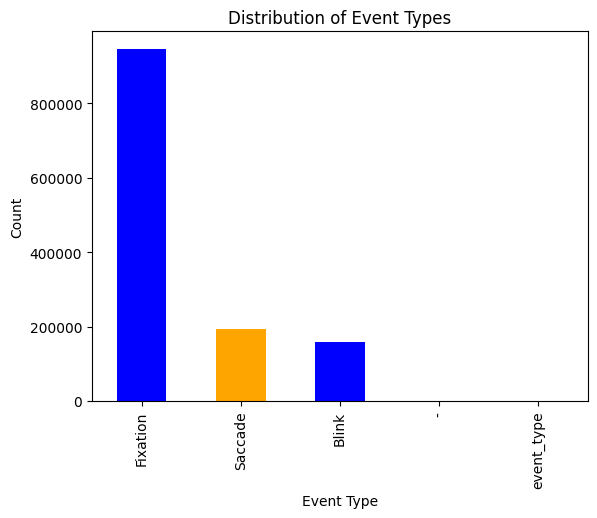

In [ ]:
# Bar plot for events fixation, saccade, and blink
event_type_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

In [ ]:
def event_counter(df):
    """
    Analyzes consecutive occurrences of events within a DataFrame.

    This function calculates two things for each event type in the DataFrame:
    1. The length of consecutive sequences of each event type.
    2. The number of times each event type appears consecutively in these sequences.

    Args:
        df (pd.DataFrame): DataFrame containing at least a column named 'event_type'.

    Returns:
        pd.Series: A Series with the count of consecutive occurrences of each event type.
    """
    result = df.groupby(df['event_type'].ne(df['event_type'].shift()).cumsum())['event_type'].value_counts() # This line had an indentation error
    return result

event_counts = gaze_data.groupby('file_number').apply(event_counter) # Also, '-' was used instead of '_' in the function name
event_counts


file_number  event_type  event_type
1            1           Fixation       1
             2           Saccade        4
             3           Fixation      40
             4           Saccade        7
             5           Fixation      23
                                       ..
74           1496        Fixation      14
             1497        Saccade        5
             1498        Fixation      51
             1499        Saccade        4
             1500        Fixation       2
Name: count, Length: 103322, dtype: int64

In [ ]:
print(event_counts.head())


file_number  event_type  event_type
1            1           Fixation       1
             2           Saccade        4
             3           Fixation      40
             4           Saccade        7
             5           Fixation      23
Name: count, dtype: int64


In [ ]:
print(event_counts.index)

MultiIndex([( 1,    1, 'Fixation'),
            ( 1,    2,  'Saccade'),
            ( 1,    3, 'Fixation'),
            ( 1,    4,  'Saccade'),
            ( 1,    5, 'Fixation'),
            ( 1,    6,  'Saccade'),
            ( 1,    7, 'Fixation'),
            ( 1,    8,  'Saccade'),
            ( 1,    9, 'Fixation'),
            ( 1,   10,  'Saccade'),
            ...
            (74, 1491,  'Saccade'),
            (74, 1492, 'Fixation'),
            (74, 1493,  'Saccade'),
            (74, 1494, 'Fixation'),
            (74, 1495,  'Saccade'),
            (74, 1496, 'Fixation'),
            (74, 1497,  'Saccade'),
            (74, 1498, 'Fixation'),
            (74, 1499,  'Saccade'),
            (74, 1500, 'Fixation')],
           names=['file_number', 'event_type', 'event_type'], length=103322)


# Saccade Analysis

In [ ]:
saccade_rows = event_counts[event_counts.index.isin(['Saccade'], level=2)]

In [ ]:
saccade_rows

file_number  event_type  event_type
1            2           Saccade        4
             4           Saccade        7
             6           Saccade       10
             8           Saccade        2
             10          Saccade        3
                                       ..
74           1491        Saccade        6
             1493        Saccade        3
             1495        Saccade        5
             1497        Saccade        5
             1499        Saccade        4
Name: count, Length: 44789, dtype: int64

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
# Saccade Analysis
saccade_rows = event_counts[event_counts.index.isin(['Saccade'], level=2)]
saccade_rows = saccade_rows.to_frame()
saccade_rows = saccade_rows.reset_index(names=['file_number', 'event_type', 'event_number'])

In [ ]:
# Average Saccade Count per File
average_counts = saccade_rows.groupby('file_number')['count'].mean()


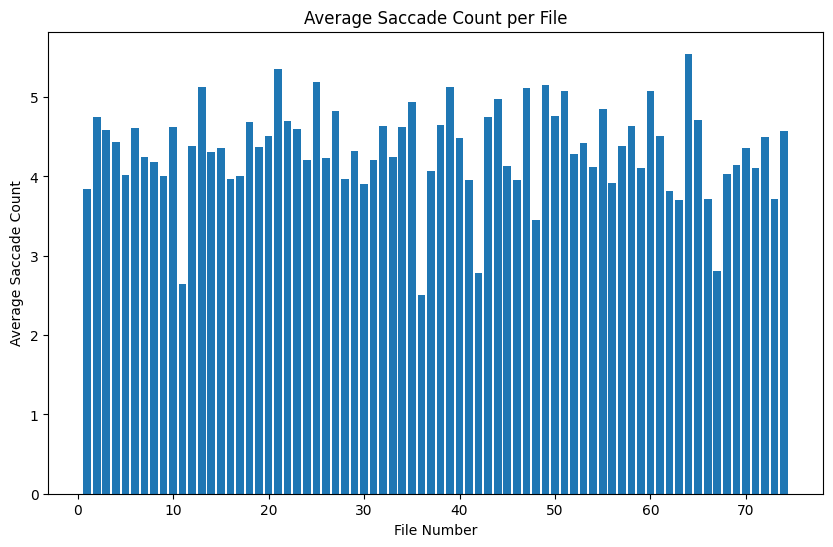

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(average_counts.index, average_counts.values)
plt.xlabel('File Number')
plt.ylabel('Average Saccade Count')
_ = plt.title('Average Saccade Count per File')


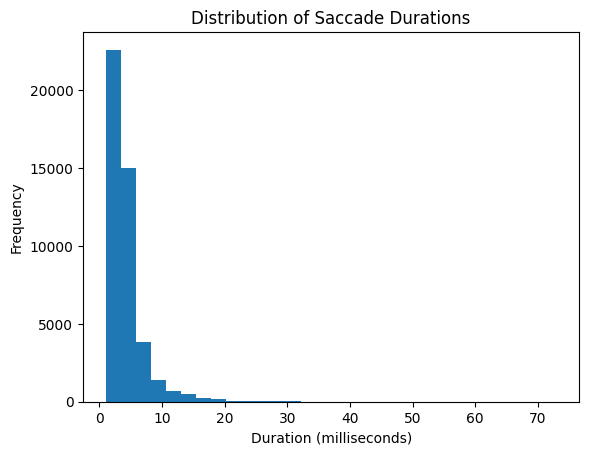

In [ ]:
# Distribution of Saccade Durations
plt.hist(saccade_rows['count'], bins=30)
plt.title('Distribution of Saccade Durations')
plt.xlabel('Duration (milliseconds)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Saccade Statistics
saccade_stats = saccade_rows.groupby('file_number')['count'].agg(['mean', 'std', 'min', 'max'])
print(saccade_stats)

                 mean       std  min  max
file_number                              
1            3.836986  2.679906    2   33
2            4.750000  3.422490    1   33
3            4.586621  2.814840    2   18
4            4.432308  2.578064    2   25
5            4.023513  2.629631    2   41
...               ...       ...  ...  ...
70           4.354098  2.957697    2   45
71           4.105634  3.084255    2   25
72           4.494505  2.796907    2   25
73           3.713462  1.987585    2   21
74           4.571223  3.109951    2   36

[74 rows x 4 columns]


In [ ]:
# Merge with Design Data
merged_saccade_data = pd.merge(saccade_rows, design, on='file_number')
merged_saccade_data = merged_saccade_data.drop(['event_type', 'D'], axis=1)

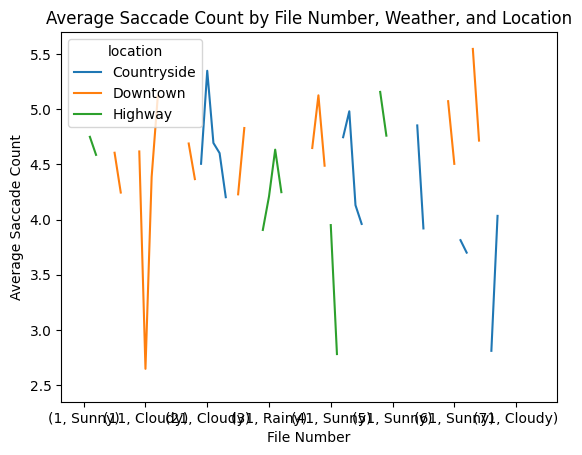

In [ ]:
# Average Count by File Number, Weather, and Location
avg_saccade_count = merged_saccade_data.groupby(['file_number', 'weather', 'location'])['count'].mean().unstack()
avg_saccade_count.plot(kind='line')
plt.xlabel('File Number')
plt.ylabel('Average Saccade Count')
_ = plt.title('Average Saccade Count by File Number, Weather, and Location')

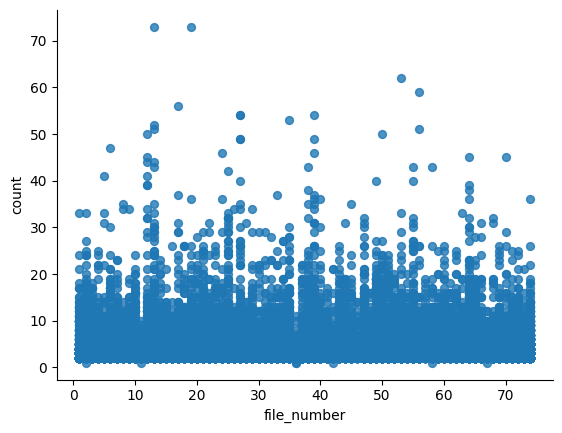

In [ ]:
merged_saccade_data.plot(kind='scatter', x='file_number', y='count', s=32, alpha=.8)
plt.title('Saccade Count by File Number')  # Adding a title
plt.gca().spines[['top', 'right']].set_visible(False)


In [ ]:
# Merge with Saccade Statistics
merged_saccade_data = pd.merge(design, saccade_stats, on='file_number')


<Figure size 1000x600 with 0 Axes>

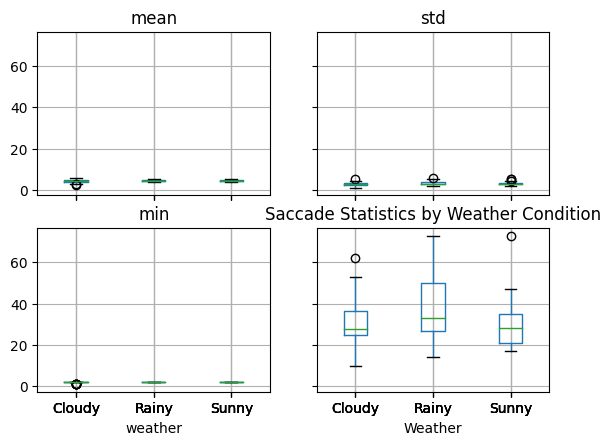

In [ ]:
# Saccade Statistics by Weather Condition
plt.figure(figsize=(10, 6))
merged_saccade_data.boxplot(column=['mean', 'std', 'min', 'max'], by='weather')
plt.title('Saccade Statistics by Weather Condition')
plt.xlabel('Weather')
plt.ylabel('Saccade Statistic')
plt.suptitle('')
plt.show()


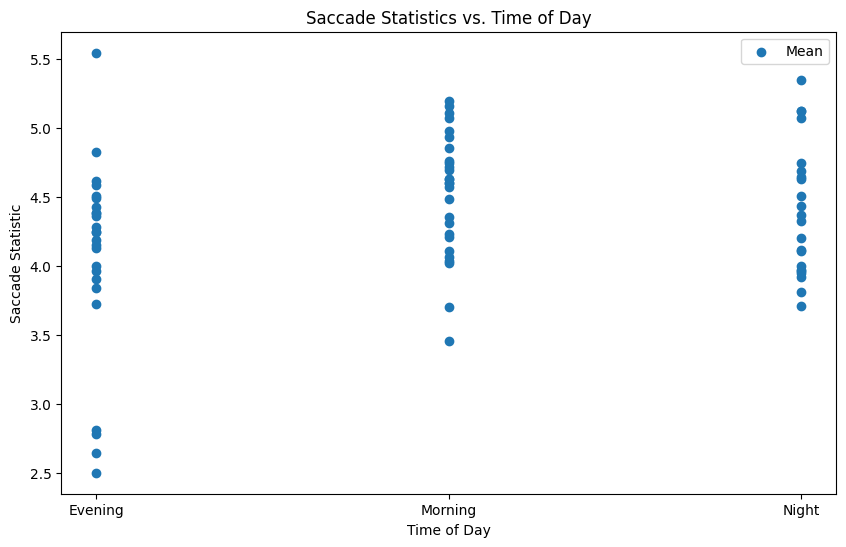

In [ ]:

# Saccade Statistics vs. Time of Day
plt.figure(figsize=(10, 6))
plt.scatter(merged_saccade_data['time'], merged_saccade_data['mean'], label='Mean')
plt.title('Saccade Statistics vs. Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Saccade Statistic')
plt.legend()
plt.show()

In [ ]:
# Numeric Mappings for Correlation
time_mapping = {'Morning': 1, 'Afternoon': 2, 'Evening': 3}
merged_saccade_data['time_numeric'] = merged_saccade_data['time'].map(time_mapping)
weather_mapping = {'Sunny': 1, 'Cloudy': 2, 'Rainy': 3}
merged_saccade_data['weather_numeric'] = merged_saccade_data['weather'].map(weather_mapping)
location_mapping = {'Urban': 1, 'Suburban': 2, 'Rural': 3}
merged_saccade_data['location_numeric'] = merged_saccade_data['location'].map(location_mapping)

In [ ]:
# Correlation Matrix
print(merged_saccade_data.corr(numeric_only=True))

                      mean       std       min       max  time_numeric  \
mean              1.000000  0.744073  0.499534  0.429682     -0.374028   
std               0.744073  1.000000  0.351872  0.787353     -0.166001   
min               0.499534  0.351872  1.000000  0.244145     -0.208397   
max               0.429682  0.787353  0.244145  1.000000     -0.172734   
time_numeric     -0.374028 -0.166001 -0.208397 -0.172734      1.000000   
weather_numeric   0.011280  0.123443 -0.009974  0.210561     -0.161898   
location_numeric       NaN       NaN       NaN       NaN           NaN   

                  weather_numeric  location_numeric  
mean                     0.011280               NaN  
std                      0.123443               NaN  
min                     -0.009974               NaN  
max                      0.210561               NaN  
time_numeric            -0.161898               NaN  
weather_numeric          1.000000               NaN  
location_numeric             

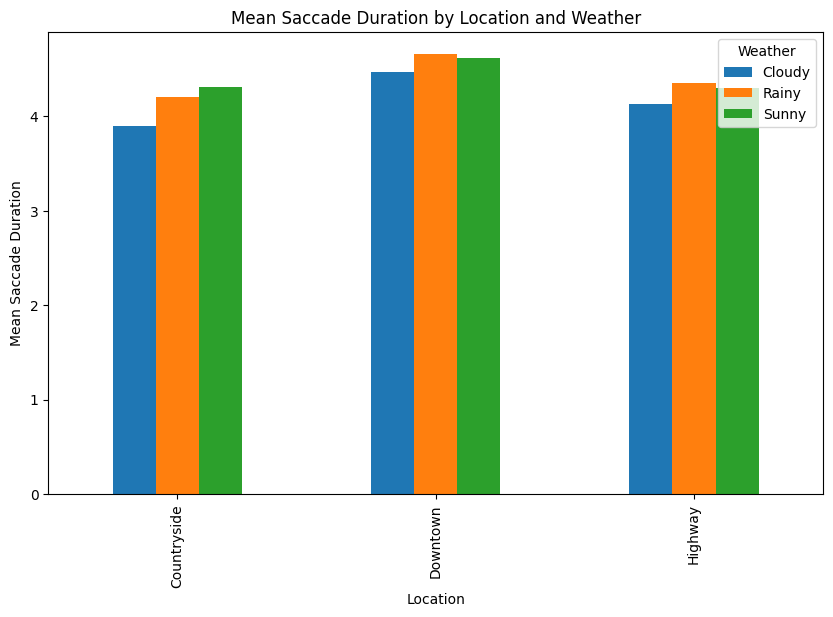

In [ ]:
# Mean Saccade Duration by Location and Weather
mean_saccade_by_location_weather = merged_saccade_data.groupby(['location', 'weather'])['mean'].mean().unstack()
mean_saccade_by_location_weather.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Saccade Duration by Location and Weather')
plt.xlabel('Location')
plt.ylabel('Mean Saccade Duration')
plt.legend(title='Weather')
plt.show()


In [ ]:
gaze_data

,file_number,frame_etg,frame_gar,X,Y,event_type,code,timestamp
0,1,0,0.0,313.81,256.40,Fixation,911066603,0.000000
1,1,0,0.0,313.56,258.52,Saccade,911083143,0.000000
2,1,1,1.0,292.11,259.90,Saccade,911099864,0.033333
3,1,1,1.0,185.82,306.49,Saccade,911116251,0.033333
4,1,2,2.0,143.25,322.21,Saccade,911133030,0.066667
...,...,...,...,...,...,...,...,...
1301245,74,8999,7499.0,405.71,207.12,Saccade,709796963,249.966667
1301246,74,8999,7499.0,495.73,179.57,Saccade,709813635,249.966667
1301247,74,9000,7500.0,589.77,152.12,Saccade,709830213,250.000000
1301248,74,9000,7500.0,690.76,123.23,Fixation,709847356,250.000000


In [ ]:

import math

def calculate_saccade_metrics(df):
  """
  Calculates the distance and velocity for each saccade in a DataFrame.

  Args:
    df: A pandas DataFrame containing saccade data.

  Returns:
    A new DataFrame with distance and velocity columns added.
  """

  df_new = df.copy()
  df["time_dif"] =  df['timestamp'].diff()
  df['X'] = pd.to_numeric(df['X'], errors='coerce')
  df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
  df['distance'] = np.sqrt((df['X'].diff().fillna(0) ** 2) + (df['Y'].diff().fillna(0) ** 2))

  return df

# Filter data for saccades
saccade_data = gaze_data[gaze_data['event_type'] == 'Saccade']

# Calculate saccade metrics for each file number
saccade_data_with_metrics = saccade_data.groupby('file_number').apply(calculate_saccade_metrics).reset_index(drop=True)

print(saccade_data_with_metrics)


        file_number frame_etg  frame_gar       X       Y event_type  \
0                 1         0        0.0  313.56  258.52    Saccade   
1                 1         1        1.0  292.11  259.90    Saccade   
2                 1         1        1.0  185.82  306.49    Saccade   
3                 1         2        2.0  143.25  322.21    Saccade   
4                 1        22       18.0  278.68  223.80    Saccade   
...             ...       ...        ...     ...     ...        ...   
194357           74      8972     7477.0  381.40  219.23    Saccade   
194358           74      8998     7498.0  386.97  208.07    Saccade   
194359           74      8999     7499.0  405.71  207.12    Saccade   
194360           74      8999     7499.0  495.73  179.57    Saccade   
194361           74      9000     7500.0  589.77  152.12    Saccade   

             code   timestamp  time_dif    distance  
0       911083143    0.000000       NaN    0.000000  
1       911099864    0.033333  0.033333

In [ ]:

import pandas as pd
import numpy as np
def calculate_saccade_metrics(df):
  """
  Calculates the distance and velocity for each saccade in a DataFrame.

  Args:
    df: A pandas DataFrame containing saccade data.

  Returns:
    A new DataFrame with distance and velocity columns added.
  """

  df_new = df.copy()
  df["time_dif"] =  df['timestamp'].diff()
  df['X'] = pd.to_numeric(df['X'], errors='coerce')
  df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
  df['distance'] = np.sqrt((df['X'].diff().fillna(0) ** 2) + (df['Y'].diff().fillna(0) ** 2))
  # Replace zero or NaN time differences with 1/30
  df['time_dif'] = df['time_dif'].replace({0: 1/30, np.nan: 1/30})
  # Calculate velocity
  df['velocity'] = df['distance'] / df['time_dif']

  return df


In [ ]:

# Calculate saccade metrics for each file number
saccade_data_with_metrics = saccade_data.groupby('file_number').apply(calculate_saccade_metrics).reset_index(drop=True)

print(saccade_data_with_metrics)

        file_number frame_etg  frame_gar       X       Y event_type  \
0                 1         0        0.0  313.56  258.52    Saccade   
1                 1         1        1.0  292.11  259.90    Saccade   
2                 1         1        1.0  185.82  306.49    Saccade   
3                 1         2        2.0  143.25  322.21    Saccade   
4                 1        22       18.0  278.68  223.80    Saccade   
...             ...       ...        ...     ...     ...        ...   
194357           74      8972     7477.0  381.40  219.23    Saccade   
194358           74      8998     7498.0  386.97  208.07    Saccade   
194359           74      8999     7499.0  405.71  207.12    Saccade   
194360           74      8999     7499.0  495.73  179.57    Saccade   
194361           74      9000     7500.0  589.77  152.12    Saccade   

             code   timestamp  time_dif    distance     velocity  
0       911083143    0.000000  0.033333    0.000000     0.000000  
1       91109

             velocity    distance
weather                          
Cloudy   11758.828333  408.397388
Rainy     4098.694178  169.159090
Sunny     9682.401495  338.765743
             velocity    distance
time                             
Evening   4663.940840  167.061298
Morning  11338.120989  415.834413
Night     8926.589858  307.229264
                velocity    distance
location                            
Countryside  8142.465603  309.372163
Downtown     7891.293625  274.894621
Highway      9971.463089  350.849841


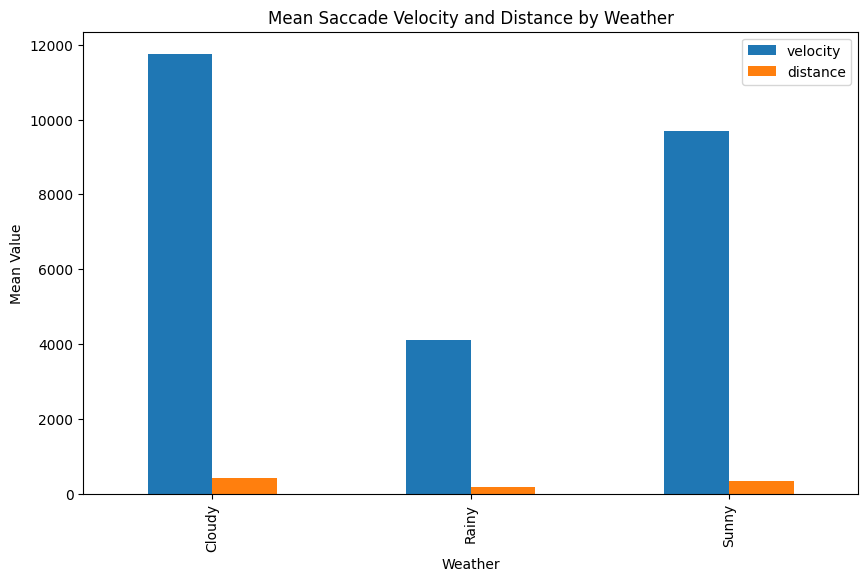

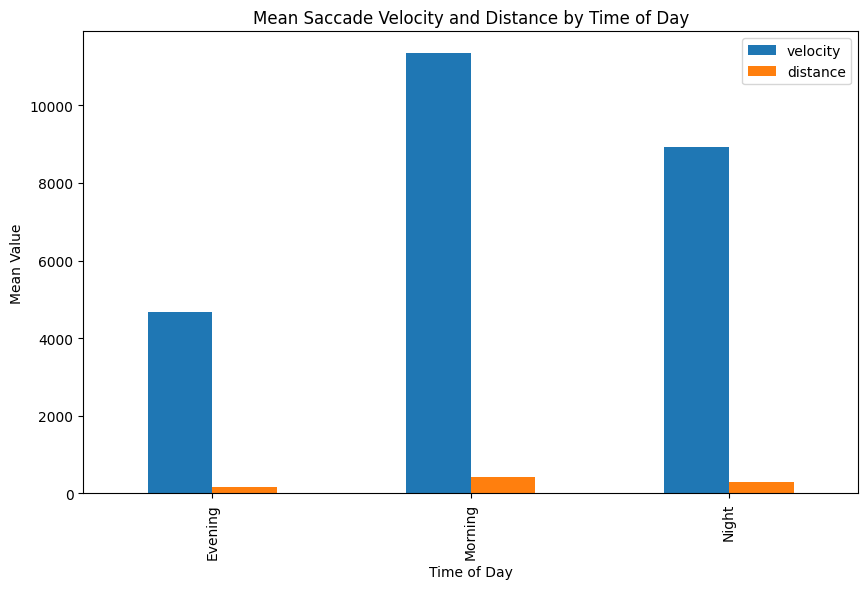

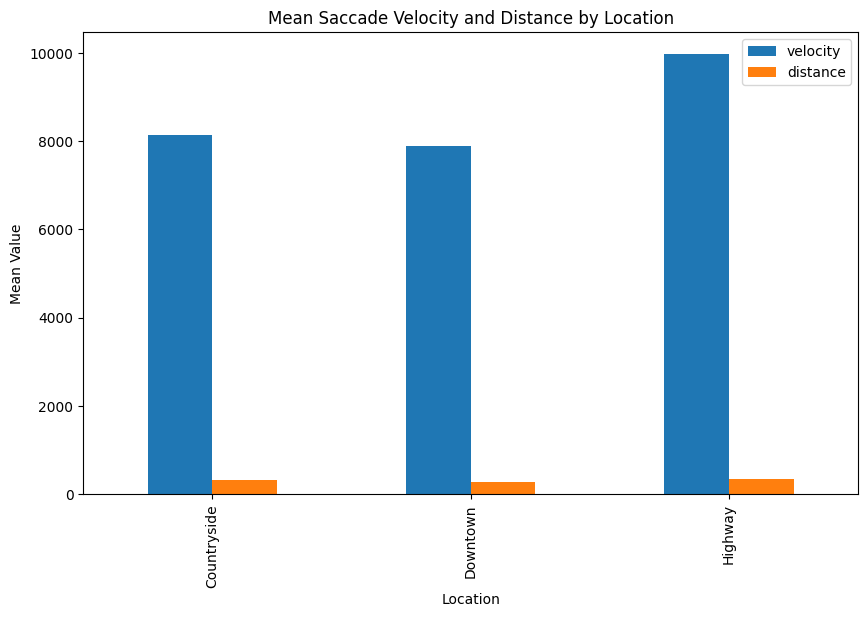

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Merge the two DataFrames on 'file_number'
merged_saccade_data = pd.merge(design, saccade_data_with_metrics, on='file_number')

# Group the data by weather and calculate the mean velocity and distance
grouped_by_weather = merged_saccade_data.groupby('weather')[['velocity', 'distance']].mean()
print(grouped_by_weather)

# Group the data by time and calculate the mean velocity and distance
grouped_by_time = merged_saccade_data.groupby('time')[['velocity', 'distance']].mean()
print(grouped_by_time)

# Group the data by location and calculate the mean velocity and distance
grouped_by_location = merged_saccade_data.groupby('location')[['velocity', 'distance']].mean()
print(grouped_by_location)

# Visualize the relationship between weather and mean velocity/distance
grouped_by_weather.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Saccade Velocity and Distance by Weather')
plt.xlabel('Weather')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Visualize the relationship between time of day and mean velocity/distance
grouped_by_time.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Saccade Velocity and Distance by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Visualize the relationship between location and mean velocity/distance
grouped_by_location.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Saccade Velocity and Distance by Location')
plt.xlabel('Location')
plt.ylabel('Mean Value')
plt.legend()
plt.show()


In [ ]:
# Median and Interquartile Range (IQR): Assess the central tendency and spread.
# Skewness and Kurtosis: Understand the distribution's shape, whether it is skewed or has heavy/light tails.

# Calculate descriptive statistics for velocity and distance
velocity_stats = saccade_data_with_metrics['velocity'].describe()
distance_stats = saccade_data_with_metrics['distance'].describe()

# Calculate skewness and kurtosis
velocity_skewness = saccade_data_with_metrics['velocity'].skew()
velocity_kurtosis = saccade_data_with_metrics['velocity'].kurtosis()
distance_skewness = saccade_data_with_metrics['distance'].skew()
distance_kurtosis = saccade_data_with_metrics['distance'].kurtosis()

print("Velocity Statistics:\n", velocity_stats)
print("\nDistance Statistics:\n", distance_stats)
print("\nVelocity Skewness:", velocity_skewness)
print("Velocity Kurtosis:", velocity_kurtosis)
print("\nDistance Skewness:", distance_skewness)
print("Distance Kurtosis:", distance_kurtosis)


Velocity Statistics:
 count    1.943620e+05
mean     8.535618e+03
std      7.505229e+05
min      0.000000e+00
25%      1.292091e+02
50%      3.471870e+02
75%      1.084175e+03
max      2.082317e+08
Name: velocity, dtype: float64

Distance Statistics:
 count    1.943620e+05
mean     3.061657e+02
std      2.521572e+04
min      0.000000e+00
25%      8.066497e+00
50%      1.941288e+01
75%      4.741684e+01
max      6.941055e+06
Name: distance, dtype: float64

Velocity Skewness: 234.93424301047716
Velocity Kurtosis: 62320.27117290481

Distance Skewness: 230.2895998350244
Distance Kurtosis: 60429.25134658211


In [ ]:


# Calculate average velocity and distance for each file number
average_metrics = saccade_data_with_metrics.groupby('file_number')[['velocity', 'distance']].mean()

print(average_metrics)


                 velocity     distance
file_number                           
1              774.879306    32.624823
2            33993.047652  1155.833785
3              901.907883    41.055181
4             1236.036793    53.214603
5              864.548474    36.016494
...                   ...          ...
70            1194.569297    50.372769
71            1208.464672    51.751177
72             865.700388    38.495805
73            1048.717234    48.843168
74            2564.091475    99.505789

[74 rows x 2 columns]


In [ ]:
# Median and Interquartile Range (IQR): Assess the central tendency and spread.
# Skewness and Kurtosis: Under

# Merge the two DataFrames on 'file_number'
merged_data = pd.merge(design, saccade_data_with_metrics, on='file_number')

# Group the data by file number
grouped_data = merged_data.groupby('file_number')

# Calculate descriptive statistics for each file
for file_number, group in grouped_data:
  print(f"File Number: {file_number}")

  # Mean and Standard Deviation
  mean_velocity = group['velocity'].mean()
  std_velocity = group['velocity'].std()
  mean_distance = group['distance'].mean()
  std_distance = group['distance'].std()
  print(f"  Mean Velocity: {mean_velocity:.2f}, Standard Deviation: {std_velocity:.2f}")
  print(f"  Mean Distance: {mean_distance:.2f}, Standard Deviation: {std_distance:.2f}")

  # Median and Interquartile Range (IQR)
  median_velocity = group['velocity'].median()
  iqr_velocity = group['velocity'].quantile(0.75) - group['velocity'].quantile(0.25)
  median_distance = group['distance'].median()
  iqr_distance = group['distance'].quantile(0.75) - group['distance'].quantile(0.25)
  print(f"  Median Velocity: {median_velocity:.2f}, IQR: {iqr_velocity:.2f}")
  print(f"  Median Distance: {median_distance:.2f}, IQR: {iqr_distance:.2f}")

  # Skewness and Kurtosis
  skewness_velocity = group['velocity'].skew()
  kurtosis_velocity = group['velocity'].kurtosis()
  skewness_distance = group['distance'].skew()
  kurtosis_distance = group['distance'].kurtosis()
  print(f"  Skewness Velocity: {skewness_velocity:.2f}, Kurtosis: {kurtosis_velocity:.2f}")
  print(f"  Skewness Distance: {skewness_distance:.2f}, Kurtosis: {kurtosis_distance:.2f}")
  print("\n")


File Number: 1
  Mean Velocity: 774.88, Standard Deviation: 2265.77
  Mean Distance: 32.62, Standard Deviation: 78.62
  Median Velocity: 286.33, IQR: 673.72
  Median Distance: 16.39, IQR: 26.68
  Skewness Velocity: 12.54, Kurtosis: 200.75
  Skewness Distance: 11.48, Kurtosis: 171.40


File Number: 2
  Mean Velocity: 33993.05, Standard Deviation: 916823.53
  Mean Distance: 1155.83, Standard Deviation: 30561.22
  Median Velocity: 448.84, IQR: 1544.14
  Median Distance: 22.89, IQR: 60.31
  Skewness Velocity: 41.75, Kurtosis: 1761.05
  Skewness Distance: 41.75, Kurtosis: 1760.83


File Number: 3
  Mean Velocity: 901.91, Standard Deviation: 3822.90
  Mean Distance: 41.06, Standard Deviation: 136.26
  Median Velocity: 295.60, IQR: 755.99
  Median Distance: 15.75, IQR: 33.68
  Skewness Velocity: 23.25, Kurtosis: 615.90
  Skewness Distance: 19.29, Kurtosis: 466.56


File Number: 4
  Mean Velocity: 1236.04, Standard Deviation: 3270.61
  Mean Distance: 53.21, Standard Deviation: 126.97
  Median 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 1200x500 with 0 Axes>

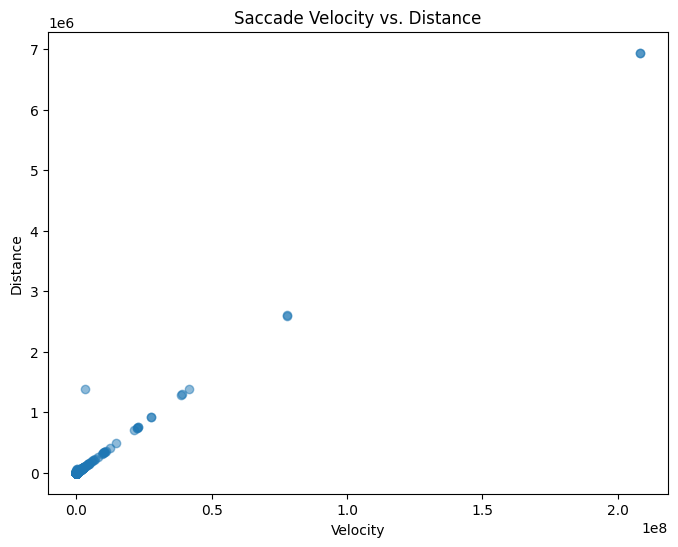

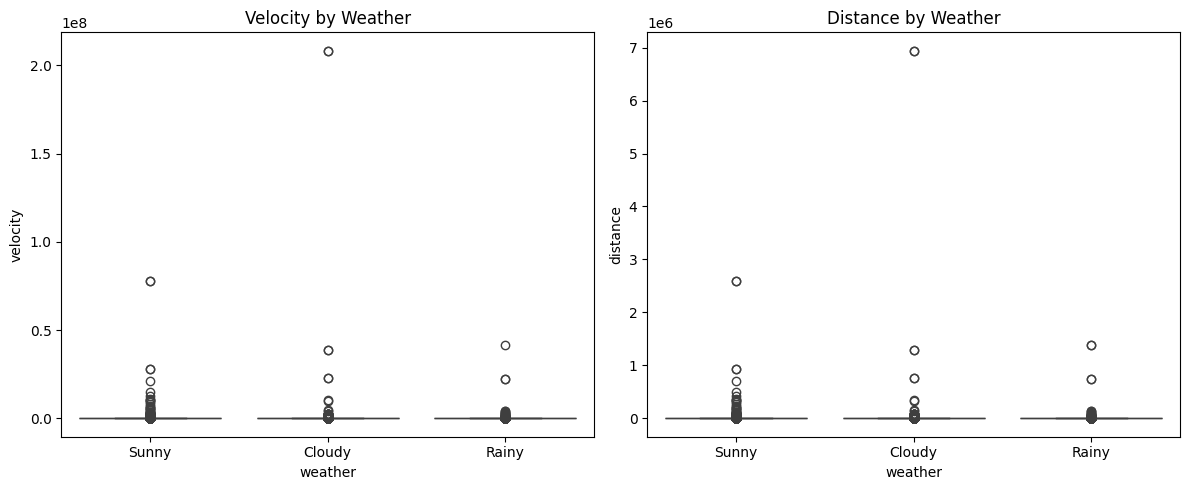

In [ ]:

import matplotlib.pyplot as plt
# Distribution of Velocity and Distance
plt.figure(figsize=(12, 5))


plt.tight_layout()
plt.show()

# Scatter plot of Velocity vs. Distance
plt.figure(figsize=(8, 6))
plt.scatter(saccade_data_with_metrics['velocity'], saccade_data_with_metrics['distance'], alpha=0.5)
plt.title('Saccade Velocity vs. Distance')
plt.xlabel('Velocity')
plt.ylabel('Distance')
plt.show()

# Box plots of Velocity and Distance by Weather
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='weather', y='velocity', data=merged_data)
plt.title('Velocity by Weather')

plt.subplot(1, 2, 2)
sns.boxplot(x='weather', y='distance', data=merged_data)
plt.title('Distance by Weather')

plt.tight_layout()
plt.show()

# Time Series Visualization (if applicable)
# If you have a time component in your data, you can visualize how velocity and distance change over time.
# For example, if 'timestamp' is a column in your DataFrame:
# merged_data.plot(x='timestamp', y=['velocity', 'distance'], kind='line', figsize=(10, 6))
# plt.title('Velocity and Distance Over Time')
# plt.xlabel('Timestamp')
# plt.ylabel('Value')
# plt.show()


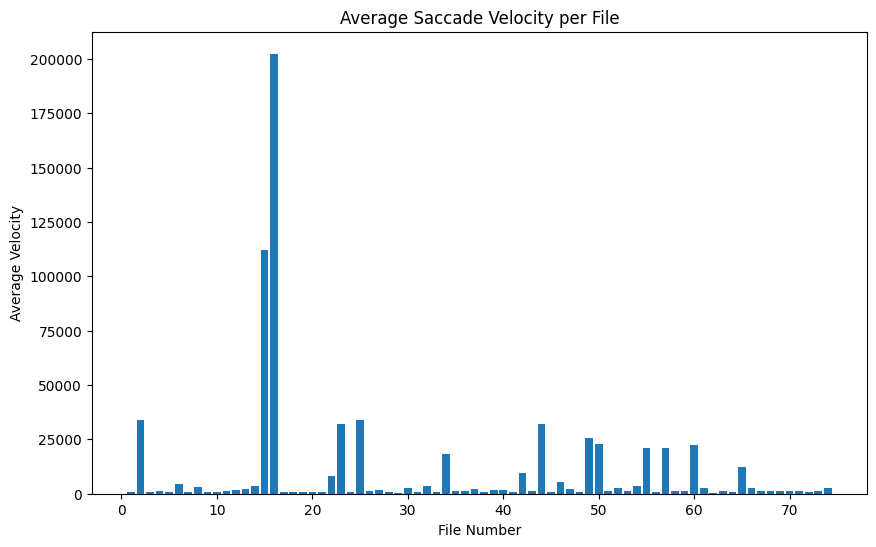

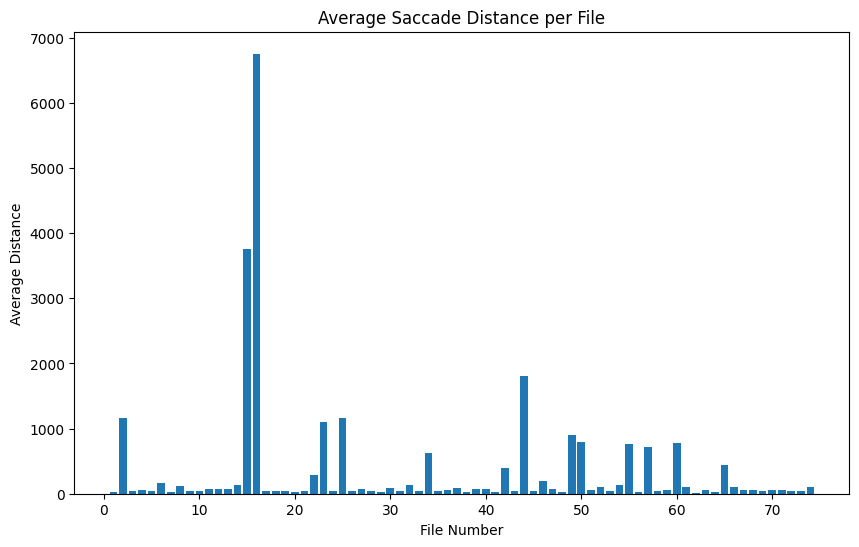

In [ ]:


import matplotlib.pyplot as plt
# Plot average velocity
plt.figure(figsize=(10, 6))
plt.bar(average_metrics.index, average_metrics['velocity'])
plt.xlabel('File Number')
plt.ylabel('Average Velocity')
plt.title('Average Saccade Velocity per File')
plt.show()

# Plot average distance
plt.figure(figsize=(10, 6))
plt.bar(average_metrics.index, average_metrics['distance'])
plt.xlabel('File Number')
plt.ylabel('Average Distance')
plt.title('Average Saccade Distance per File')
plt.show()


In [ ]:

import pandas as pd
# Get top 15 file numbers for velocity and distance
top_15_velocity = average_metrics.nlargest(20, 'velocity')
top_15_distance = average_metrics.nlargest(20, 'distance')

# Merge with design data
top_15_velocity_with_design = pd.merge(top_15_velocity, design, on='file_number')
top_15_distance_with_design = pd.merge(top_15_distance, design, on='file_number')

print("Top 15 File Numbers for Velocity:\n", top_15_velocity_with_design)
print("\nTop 15 File Numbers for Distance:\n", top_15_distance_with_design)


Top 15 File Numbers for Velocity:
     file_number       velocity     distance     time weather     location   D  \
0            16  202353.304936  6755.905662    Night  Cloudy     Downtown  D7   
1            15  112156.363226  3754.051796  Evening   Sunny  Countryside  D5   
2             2   33993.047652  1155.833785  Morning  Cloudy      Highway  D2   
3            25   33935.133028  1163.557310  Morning   Sunny      Highway  D4   
4            44   32038.866466  1808.205776  Morning   Rainy  Countryside  D1   
5            23   31886.878699  1103.178459  Morning   Sunny  Countryside  D5   
6            49   25561.125974   905.954216  Morning  Cloudy      Highway  D3   
7            50   23059.295347   790.295072  Morning   Rainy      Highway  D2   
8            60   22245.865530   785.325887  Morning  Cloudy     Downtown  D5   
9            57   21201.464396   722.869615  Evening   Sunny      Highway  D5   
10           55   20844.862090   768.286062  Morning   Sunny  Countryside 

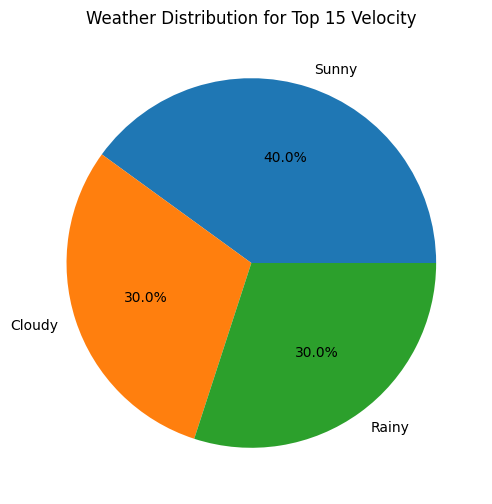

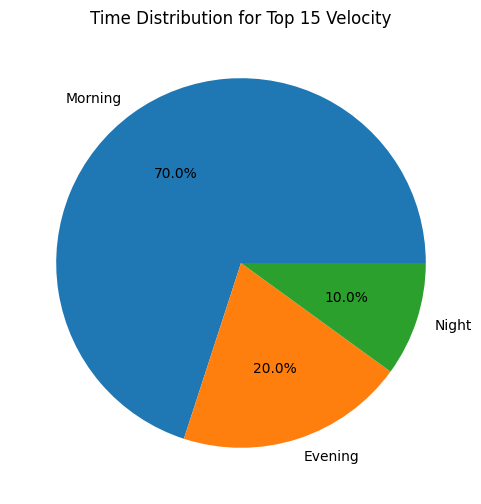

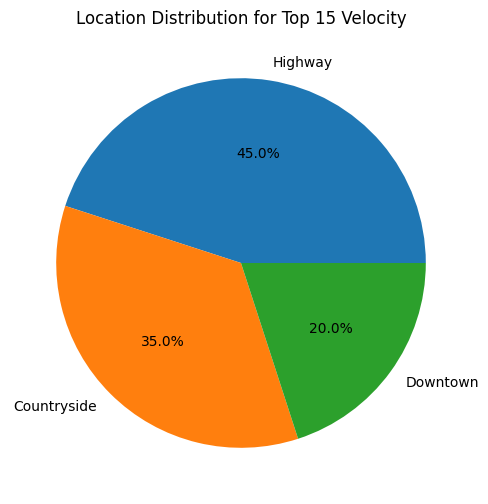

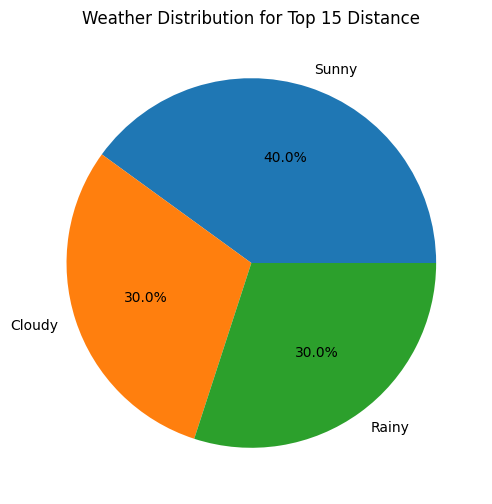

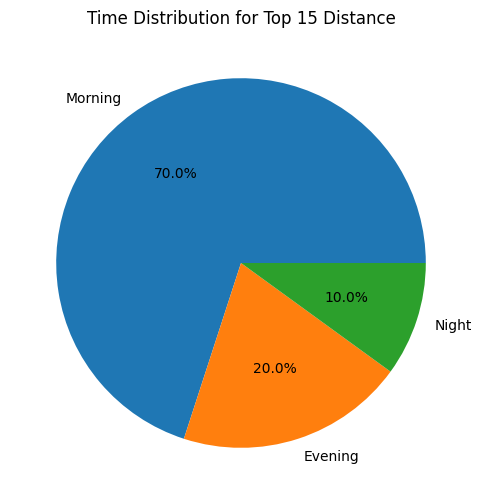

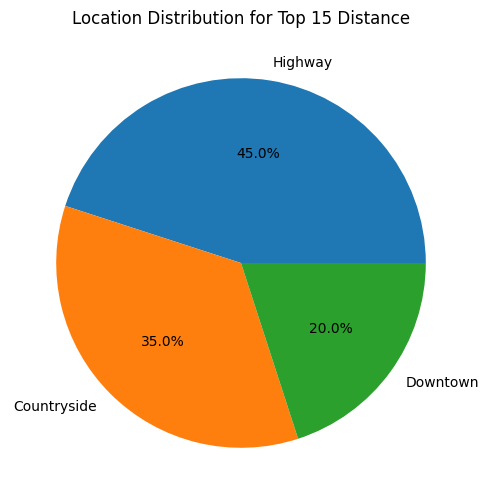

In [ ]:

import matplotlib.pyplot as plt
# Pie chart for weather in top 15 velocity
plt.figure(figsize=(6, 6))
top_15_velocity_with_design['weather'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Weather Distribution for Top 15 Velocity')
plt.ylabel('')  # Remove the default ylabel
plt.show()

# Pie chart for time in top 15 velocity
plt.figure(figsize=(6, 6))
top_15_velocity_with_design['time'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Time Distribution for Top 15 Velocity')
plt.ylabel('')
plt.show()

# Pie chart for location in top 15 velocity
plt.figure(figsize=(6, 6))
top_15_velocity_with_design['location'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Location Distribution for Top 15 Velocity')
plt.ylabel('')
plt.show()

# Pie chart for weather in top 15 distance
plt.figure(figsize=(6, 6))
top_15_distance_with_design['weather'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Weather Distribution for Top 15 Distance')
plt.ylabel('')
plt.show()

# Pie chart for time in top 15 distance
plt.figure(figsize=(6, 6))
top_15_distance_with_design['time'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Time Distribution for Top 15 Distance')
plt.ylabel('')
plt.show()

# Pie chart for location in top 15 distance
plt.figure(figsize=(6, 6))
top_15_distance_with_design['location'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Location Distribution for Top 15 Distance')
plt.ylabel('')
plt.show()


In [ ]:

import pandas as pd
# Get bottom 20 file numbers for velocity and distance
bottom_20_velocity = average_metrics.nsmallest(20, 'velocity')
bottom_20_distance = average_metrics.nsmallest(20, 'distance')

# Merge with design data
bottom_20_velocity_with_design = pd.merge(bottom_20_velocity, design, on='file_number')
bottom_20_distance_with_design = pd.merge(bottom_20_distance, design, on='file_number')

print("Bottom 20 File Numbers  for Distance:\n", bottom_20_distance_with_design)


Bottom 20 File Numbers  for Distance:
     file_number    velocity   distance     time weather     location   D  \
0            62  376.107274  18.515385    Night  Cloudy  Countryside  D6   
1            29  513.905440  23.306934    Night  Cloudy  Countryside  D8   
2            56  591.206028  24.955037    Night   Rainy  Countryside  D6   
3            41  617.805343  28.953554    Night   Sunny      Highway  D1   
4            48  702.793858  29.228648  Morning  Cloudy  Countryside  D8   
5            20  651.906824  29.898189  Evening   Sunny  Countryside  D2   
6             7  664.021668  30.060232  Evening   Rainy     Downtown  D3   
7            64  693.835687  30.121825  Evening  Cloudy     Downtown  D8   
8            38  777.008556  32.486259    Night   Sunny     Downtown  D8   
9             1  774.879306  32.624823  Evening   Sunny  Countryside  D8   
10           28  733.420951  34.842973    Night  Cloudy      Highway  D5   
11           17  891.834815  35.093837  Evening  

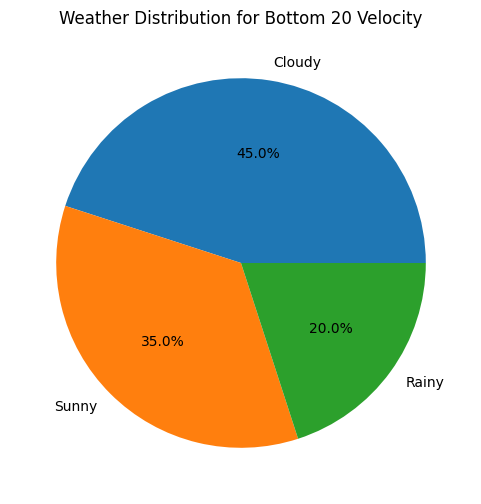

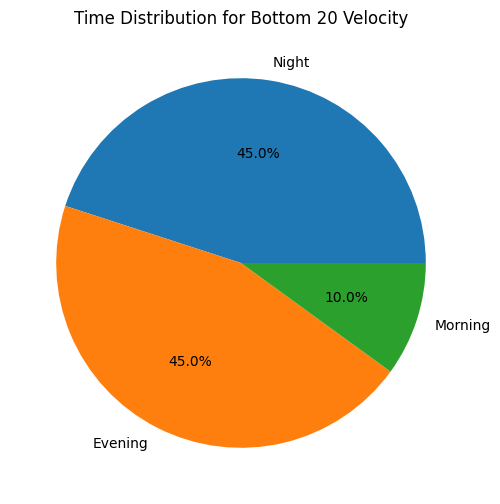

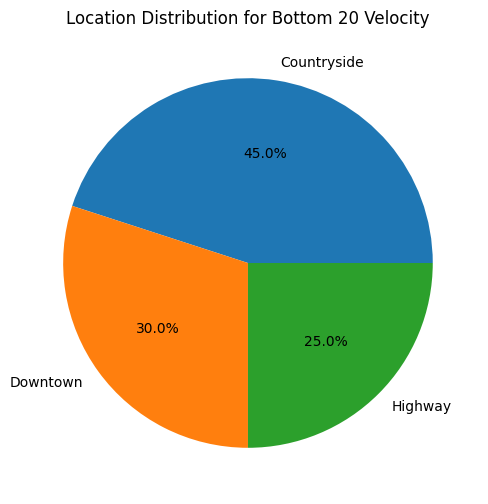

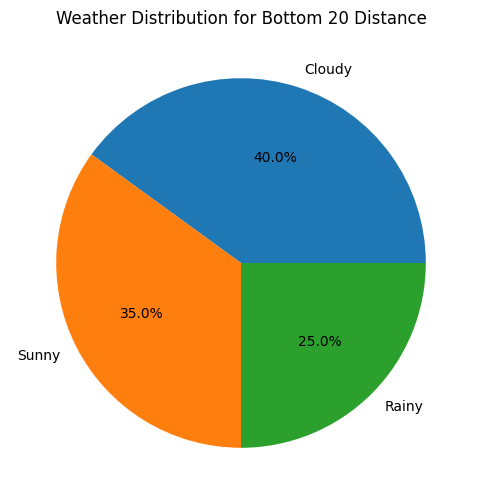

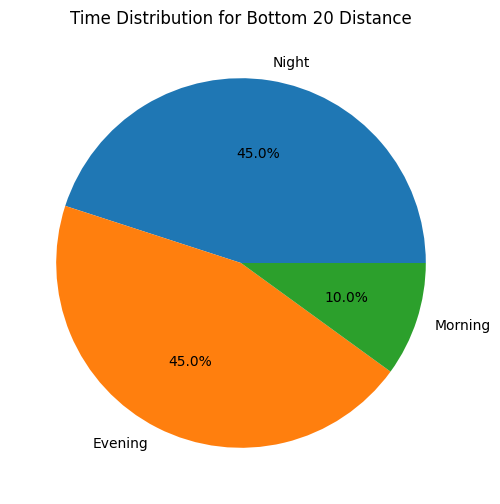

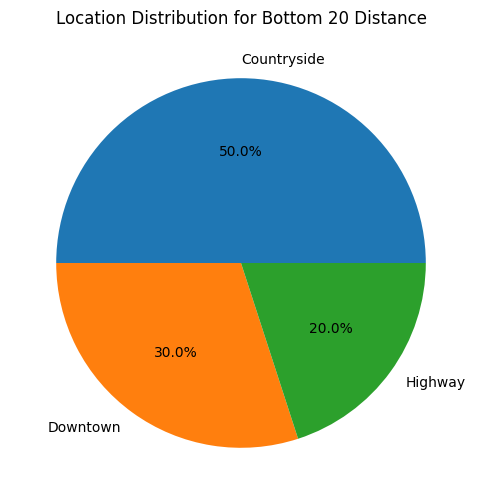

In [ ]:

import matplotlib.pyplot as plt
# Pie chart for weather in bottom 20 velocity
plt.figure(figsize=(6, 6))
bottom_20_velocity_with_design['weather'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Weather Distribution for Bottom 20 Velocity')
plt.ylabel('')  # Remove the default ylabel
plt.show()

# Pie chart for time in bottom 20 velocity
plt.figure(figsize=(6, 6))
bottom_20_velocity_with_design['time'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Time Distribution for Bottom 20 Velocity')
plt.ylabel('')
plt.show()

# Pie chart for location in bottom 20 velocity
plt.figure(figsize=(6, 6))
bottom_20_velocity_with_design['location'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Location Distribution for Bottom 20 Velocity')
plt.ylabel('')
plt.show()

# Pie chart for weather in bottom 20 distance
plt.figure(figsize=(6, 6))
bottom_20_distance_with_design['weather'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Weather Distribution for Bottom 20 Distance')
plt.ylabel('')
plt.show()

# Pie chart for time in bottom 20 distance
plt.figure(figsize=(6, 6))
bottom_20_distance_with_design['time'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Time Distribution for Bottom 20 Distance')
plt.ylabel('')
plt.show()

# Pie chart for location in bottom 20 distance
plt.figure(figsize=(6, 6))
bottom_20_distance_with_design['location'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Location Distribution for Bottom 20 Distance')
plt.ylabel('')
plt.show()


In [ ]:

def calculate_saccade_velocity(data):
  """
  Calculates saccade velocity from gaze data, excluding blinks and fixations.

  Args:
    data: Pandas DataFrame containing gaze data.

  Returns:
    Pandas DataFrame with saccade events and calculated velocities.
  """

  # Filter for saccade events only
  saccades = data[data['event_type'] == 'Saccade'].copy()

  # Convert relevant columns to numeric (if needed)
  columns_to_convert = ['file_number', 'frame_etg', 'frame_gar', 'X', 'Y']
  for col in columns_to_convert:
      saccades[col] = pd.to_numeric(saccades[col], errors='coerce')

  # Calculate time difference between consecutive frames
  saccades['time_diff'] = saccades['frame_etg'].diff()

  # Calculate Euclidean distance between consecutive gaze points, handling potential NaN values
  saccades['distance'] = np.sqrt((saccades['X'].diff().fillna(0) ** 2) + (saccades['Y'].diff().fillna(0) ** 2))


  # Calculate velocity (distance / time)
  saccades['velocity'] = saccades['distance'] / saccades['time_diff']

  # Fill any NaN values (e.g., for the first saccade in a sequence) with 0
  saccades['velocity'].fillna(0, inplace=True)

  return saccades

# Assuming 'data' is your original DataFrame
saccades_only = calculate_saccade_velocity(gaze_data)

# Now you can perform your saccade analysis on the 'saccades_only' DataFrame
# ... (your analysis code here)


In [ ]:
saccades_only

,file_number,frame_etg,frame_gar,X,Y,event_type,code,timestamp,time_diff,distance,velocity
1,1,0,0.0,313.56,258.52,Saccade,911083143,0.000000,NaN,0.000000,0.000000
2,1,1,1.0,292.11,259.90,Saccade,911099864,0.033333,1.0,21.494346,21.494346
3,1,1,1.0,185.82,306.49,Saccade,911116251,0.033333,0.0,116.052541,inf
4,1,2,2.0,143.25,322.21,Saccade,911133030,0.066667,1.0,45.379768,45.379768
45,1,22,18.0,278.68,223.80,Saccade,911813394,0.600000,20.0,167.409119,8.370456
...,...,...,...,...,...,...,...,...,...,...,...
1301192,74,8972,7477.0,381.40,219.23,Saccade,708917237,249.233333,0.0,25.499118,inf
1301244,74,8998,7498.0,386.97,208.07,Saccade,709780384,249.933333,26.0,12.472790,0.479723
1301245,74,8999,7499.0,405.71,207.12,Saccade,709796963,249.966667,1.0,18.764064,18.764064
1301246,74,8999,7499.0,495.73,179.57,Saccade,709813635,249.966667,0.0,94.141398,inf


In [ ]:
saccades_only.columns

Index(['file_number', 'frame_etg', 'frame_gar', 'X', 'Y', 'event_type', 'code',
       'timestamp', 'time_diff', 'distance', 'velocity'],
      dtype='object')

In [ ]:
saccades_only.shape

(194362, 11)

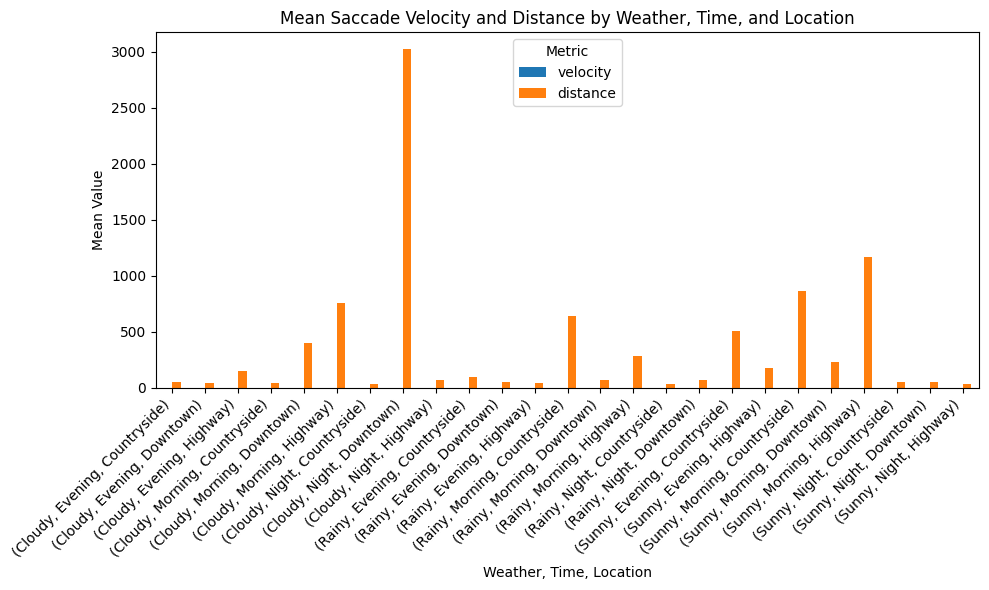

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
# Merge saccade data with design data
merged_saccade_data = pd.merge(saccades_only, design, on='file_number')
merged_saccade_data

# Group by features and calculate mean velocity and distance
grouped_data = merged_saccade_data.groupby(['weather', 'time', 'location'])[['velocity', 'distance']].mean()

# Visualize the results
grouped_data.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Saccade Velocity and Distance by Weather, Time, and Location')
plt.xlabel('Weather, Time, Location')
plt.ylabel('Mean Value')
plt.legend(title='Metric')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Optionally, you can perform statistical tests (e.g., ANOVA) to assess the significance of the differences


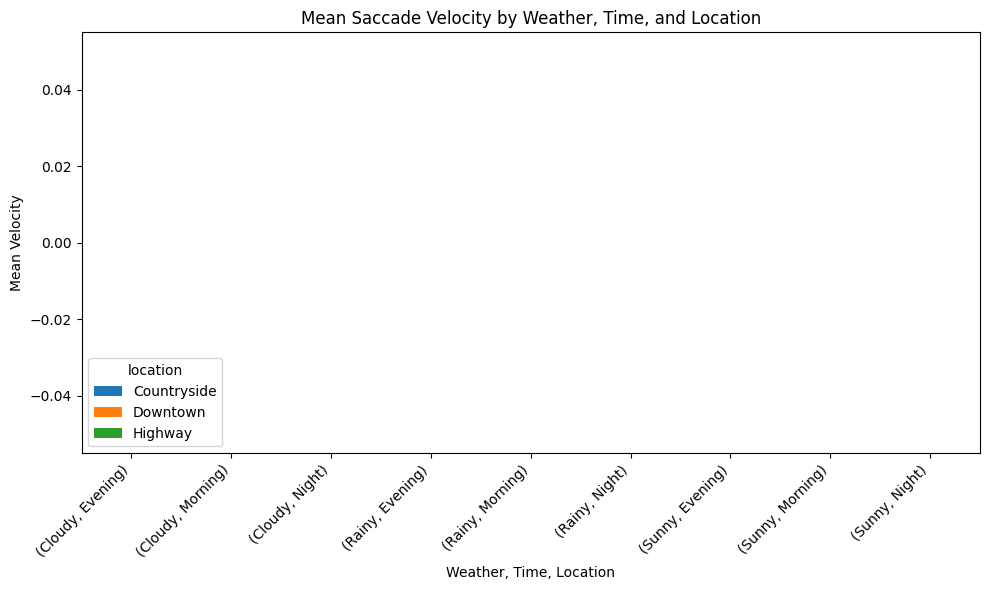

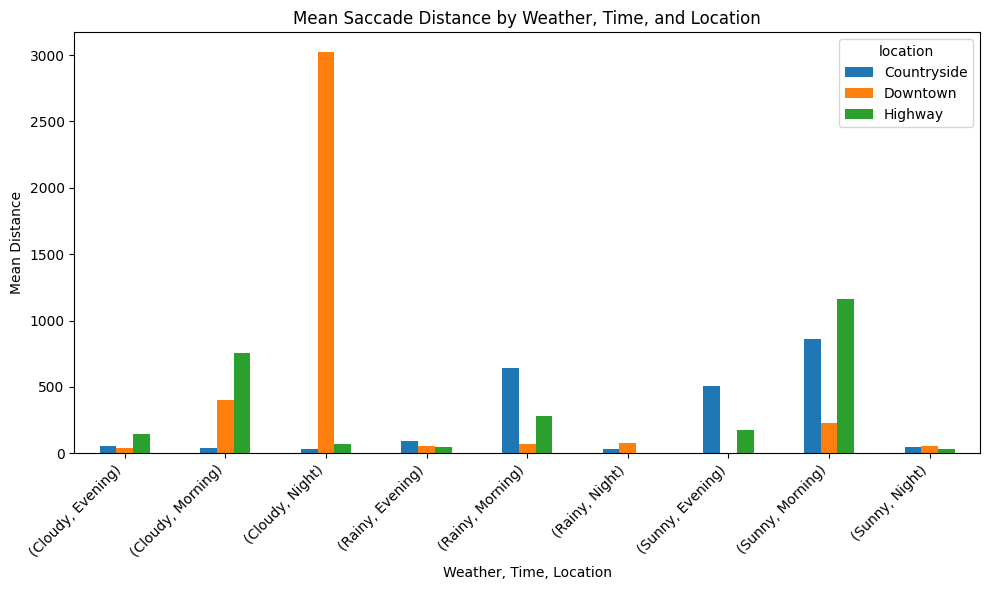

In [ ]:

import matplotlib.pyplot as plt
# Group by features and calculate mean velocity and distance
grouped_velocity = merged_saccade_data.groupby(['weather', 'time', 'location'])['velocity'].mean().unstack()
grouped_distance = merged_saccade_data.groupby(['weather', 'time', 'location'])['distance'].mean().unstack()

grouped_velocity

# Plot for velocity
grouped_velocity.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Saccade Velocity by Weather, Time, and Location')
plt.xlabel('Weather, Time, Location')
plt.ylabel('Mean Velocity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot for distance
grouped_distance.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Saccade Distance by Weather, Time, and Location')
plt.xlabel('Weather, Time, Location')
plt.ylabel('Mean Distance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
